# Основы нейронных сетей 

In [1]:
import torch
import numpy as np

In [2]:
Y = torch.rand((2, 5))
X = torch.rand((2, 3))
W = torch.rand((3, 5)).requires_grad_()  # отслеживать градиенты для этого тензора

In [3]:
for i in range(200):
    pred = X @ W
    pred_loss = torch.sum((pred - Y)**2)
    reg_loss = 0.01 * torch.sum(torch.abs(W))
    loss = pred_loss + reg_loss
    
    loss.backward()  # подсчет градиентов
    W.data.add_(-0.1 * W.grad.data)  # шаг градиент. спуска
    W.grad.zero_()  # обнуление градиента весов, чтобы не было накопления градиента

In [4]:
X @ W

tensor([[0.4805, 0.5031, 0.3423, 0.7628, 0.4291],
        [0.5654, 0.2190, 0.3507, 0.4006, 0.2436]], grad_fn=<MmBackward0>)

In [5]:
Y

tensor([[0.2289, 0.6462, 0.1482, 0.9486, 0.4987],
        [0.9153, 0.0333, 0.6223, 0.1568, 0.1582]])

# Pytorch Modules

In [6]:
import torch.optim as optim
import torch.nn as nn

In [7]:
X = torch.rand(1, 8)
y = torch.rand(1, 3)

In [8]:
model = nn.Sequential(
    nn.Linear(8, 10),
    nn.ReLU(),
    nn.Linear(10, 20), 
    nn.ReLU(),
    nn.Linear(20, 3)
)

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.03, weight_decay=0.01)

In [10]:
for i in range(250):
    optimizer.zero_grad()
    pred = model(X)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

In [11]:
def softmax(x):
    x = x.detach().numpy()
    el = np.exp(x)
    return el / np.sum(el)

In [12]:
model(X)

tensor([[ 0.2211,  0.2977, -0.7787]], grad_fn=<AddmmBackward0>)

In [13]:
y

tensor([[0.8882, 0.9600, 0.3220]])

In [14]:
softmax(model(X))

array([[0.40855807, 0.44110358, 0.15033837]], dtype=float32)

In [15]:
import torch.nn.functional as F

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(8, 10)
        self.layer2 = nn.Linear(10, 20)
        self.layer3 = nn.Linear(20, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [17]:
model = Net()

In [18]:
model(X)

tensor([[ 0.1429, -0.0869, -0.0807]], grad_fn=<AddmmBackward0>)

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.03, weight_decay=0.01)

In [20]:
for i in range(250):
    optimizer.zero_grad()
    pred = model(X)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

In [21]:
softmax(model(X))

array([[0.40819496, 0.44144863, 0.15035643]], dtype=float32)

In [22]:
y

tensor([[0.8882, 0.9600, 0.3220]])

# Data preprocessing

Нейронные сети лучше сходятся, если подавать данные одного масштаба. В противном случае признаки с большими значениями могут доминировать над признаками с меньшими значениями. Также это важно при инициализации весов (например, Xavier), так как предполагатеся, что нейроны некоторого слоя до применения функции активации выдают значения с определенной дисперсией. 

$X' = \frac{X-Mean\_X}{Std\_X}$

Стандартизация помогает нейросети на самых первых этапах тренировки нащупать, где находятся данные (около нуля с некоторым стандартным отклонением), поэтому такая система сходится лучше и быстрее.

In [224]:
from sklearn.preprocessing import StandardScaler

In [24]:
X = np.array([[10, 0.1, -1],
              [105, 0.7, 5],
              [-200, -0.9, -3],
              [500, 1, 0]])

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_scaled

array([[-0.36909109, -0.17220915, -0.42409446],
       [ 0.00492121,  0.65439476,  1.61155897],
       [-1.19585514, -1.54988233, -1.10264561],
       [ 1.56002501,  1.06769671, -0.08481889]])

# [Weight initialization](https://neerc.ifmo.ru/wiki/index.php?title=%D0%98%D0%BD%D0%B8%D1%86%D0%B8%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8)

### [Xavier initialization](https://education.yandex.ru/handbook/ml/article/tonkosti-obucheniya)

Простое инициализирование весов случайными значениями неэффективно. Вместо этого веса можно инициализировать так, чтобы дисперсия значении, которые приходят на каждый слой нейронов, оставалась примерно одинаковой на каждом слое.

Рассмотрим линейное преобразование:

$y$ = $w^{T}\cdot$ $x$ $+$ $b$ = $\sum(w_i\cdot x_i)$ + $b$ = $\sum(y_i)$ + $b$

Возьмем вектор $b$ равным $0$ (или очень малым значением), тогда дисперсия y не зависит от $b$. 

$Var$ $(X)$ = $E$ $(X^2)$ $-$ $E$ $(X)^2$ $-$ (дисперсия)

$E$ $(X)$ $-$ (математическое ожидание)

$cov$ $(X, Y)$ $-$ (ковариация)

$cov$ $(X, Y) = E[(X - E[X])(Y - E[Y])] = E[XY - XE[Y] - YE[X] + E[X]E[Y]] $

$cov$ $(X, Y) = E[XY] - E[X]E[Y] - E[Y]E[X] + E[X]E[Y] = E[XY] - E[X]E[Y] $

Если принять, что $X$ и $Y$ независимы, то $cov(X, Y)$ = $0$ поэтому $=>$ $E[XY]$ = $E[X]E[Y]$

$Var$ $(y_i)$ = $Var$ $(w_i\cdot x_i)$ = $E$ $(w_i^2\cdot x_i^2)$ $-$ $E$ $(w_i\cdot x_i)^2$

$Var$ $(y_i)$ = $cov$ $(w_i^2, x_i^2)$ + $E$ $(w_i^2)$ $\cdot$ $E$ $(x_i^2)$ $-$ $E$ $(w_i\cdot x_i)^2$

$Var$ $(y_i)$ = $cov$ $(w_i^2, x_i^2)$ + $(Var$ $(w_i)$ + $E$ $(w_i)^2)$ $\cdot$ $(Var$ $(x_i)$ + $E$ $(x_i)^2)$ $-$ $(cov$ $(w_i, x_i)$ + $E$ $(w_i)$ $\cdot$ $E$ $(x_i))^2$ ($w_i$ и $x_i$ независимы, поэтому сокращаем все $cov$)

После раскрытия скобок получаем:

$Var$ $(y_i)$ = $E$ $(x_i)^2$ $\cdot$ $Var$ $(w_i)$ + $E$ $(w_i)^2$ $\cdot$ $Var$ $(x_i)$ + $Var$ $(w_i)$ $\cdot$ $Var$ $(x_i)$

Так как мы сами выбираем параметры распределения, то мы их можем выбрать так, чтобы $E$ $(w_i)$ = $0$ для всех слоев. То же самое работает в случае входных $(x_i)$ значений $E$ $(x_i)$ = $0$, так как для первого слоя можно делать стандартизацию.

$(E$ $(w_i)$ = $0,$ $E$ $(x_i)$ = $0)$ $=>$ $Var$ $(y_i)$ = $Var$ $(w_i)$ $\cdot$ $Var$ $(x_i)$

Это предположение верно для первого слоя, но оно будет верно и для всех остальных слоев, если использовать симметричную относительно нуля функцию активации $(Tanh)$, которая будет сохранять нулевое математическое ожидание. 

$Var$ $(y)$ = $Var$ $(\sum_{i=1}^{n_{in}}y_i)$ = $\sum_{i=1}^{n_{in}}Var(y_i)$ = $n_{in}$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $Var$ $(x_i)$

Таким образом, дисперсия входных данных $x_i$ линейно зависит от дисперсии результата с коэффициентом $n_{in}$ $\cdot$ $Var$ $(w_i)$

Поэтому из условия $Var$ $(y)$ = $Var$ $(x_i)$ $=>$ $Var$ $(w_i)$ = $\frac{1}{n_{in}}$ $=>$ дисперсия входных значений на каждом слое будет сохраняться на одинаковом уровне. То же самое работает в обратном проходе, только будет $\frac{1}{n_{out}}$.

Для начальной инициализации параметров стоит использовать такое распределение, что $Var$ $(w_i)$ = $\frac{1}{n_{in}}$ и $Var$ $(w_i)$ = $\frac{1}{n_{out}}$, которое позволит контролировать изменение дисперсии.

Предыдущий подход хорошо работает, когда размерность наших данных не изменяется после преобразований $(n_{in}=n_{out})$, но так бывает не всегда. 

Поэтому используется $Var$ $(w_i)$ = $\frac{1}{\frac{n_{in} + n_{out}}{2}}$ = $\frac{2}{n_{in} + n_{out}}$

$w_i$ ~ $\mathcal{N}(0, \frac{2}{n_{in} + n_{out}})$

Для инициализации Xavier должно выполняться условие симметричной функции активации. Но ReLU не симметрична относительно нуля.

### He initialization

Эта инициализация учитывает особенности функции активации ReLU. Так как ReLU несимметричная функция активации $\mathcal{f}(x)$ = $max(0, x)$, мы не сможем утверждать, что мат. ожидание входных значении на каждом слое будет нулевым.

$(E$ $(w_i)$ = $0,$ $E$ $(x_i)$ ≠ $0)$ $=>$ $Var$ $(y_i)$ = $E$ $(x_i)^2$ $\cdot$ $Var$ $(w_i)$ + $Var$ $(w_i)$ $\cdot$ $Var$ $(x_i)$ = $Var$ $(w_i)$ $\cdot$ $(E$ $(x_i)^2$ + $Var$ $(x_i))$ = $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)$

$Var$ $(y)$ = $Var$ $(\sum_{i=1}^{n_{in}}y_i)$ = $\sum_{i=1}^{n_{in}}Var(y_i)$ = $n_{in}$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)$

Поэтому мы будем пытаться контролировать дисперсию не между слоями, а между входами ReLU. 

$x$ = $ReLU(y_{prev})$

$E$ $(y_{prev})$ = $0$, т.к. $w_{prev}$ и $x_{prev}$ независимы. Также $y_{prev}$ распределен симметрично относительно 0.

Функция $max(0, y_{prev})$ возвращает $y_{prev}$ если $y_{prev}$ неотрицательно, и $0$ если $y_{prev}$ отрицательно. В квадрате это будет $y_{prev}^2$ если $y_{prev}$ неотрицательно, и $0$ если $y_{prev}$ отрицательно.

График $max(0, y_{prev})$ при x < 0 имеет вид прямой y = 0, при x > 0 прямая. График $(y_{prev}^2)$ имеет вид параболы.

$E$ $(max(0, y_{prev})^2)$ = $∫_{-∞}^{∞} max(0, y_{prev})^2 \cdot f(y_{prev}) \cdot dy_{prev}$ = $∫_{-∞}^{0} 0 \cdot f(y_{prev}) \cdot dy_{prev}$ + $∫_{0}^{∞} y_{prev}^2 \cdot f(y_{prev}) \cdot dy_{prev}$ = $∫_{0}^{∞} y_{prev}^2 \cdot f(y_{prev}) \cdot dy_{prev}$

$E$ $(y_{prev}^2)$ = $∫_{-∞}^{∞} y_{prev}^2 \cdot f(y_{prev}) \cdot dy_{prev}$, где $f(y_{prev})$ - плотность.

$=>$ $E$ $(max(0, y_{prev})^2)$ = $\frac{1}{2} \cdot$ $E$ $(y_{prev}^2)$ 

$E$ $(x_i^2)$ = $E$ $(max(0, y_{prev})^2)$ = $\frac{1}{2} \cdot$ $E$ $(y_{prev}^2)$ = $\frac{1}{2} \cdot$ $(E$ $(y_{prev})^2$ + $Var$ $(y_{prev}))$ = $\frac{1}{2} \cdot$ $Var$ $(y_{prev})$

$Var$ $(y)$ = $n_{in}$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)$ = $\frac{1}{2} \cdot$ $n_{in}$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $Var$ $(y_{prev})$

Из $Var$ $(y)$ = $Var$ $(y_{prev})$  $=>$ $Var$ $(w_i)$ = $\frac{2}{n_{in}}$

$w_i$ ~ $\mathcal{N}(0, \frac{2}{n_{in}})$

### [Объяснение инициализации Xavier на пальцах](https://stepik.org/lesson/573086/step/1?unit=567635)

Будем считать, функция активации у всех нейронов одинаковая и удовлетворяет условиям $f(x)$ $≈$ $x$ и $f'(x)$ $≈$ $1$ вблизи нуля. Веса-смещения равны нулю или близки к нулю. Функция активации симметрична относительно $0$.

Пусть каждый нейрон левого слоя до применения функции активации имеет выходное значение в диапазоне $[-a, a]$. Тогда после применения функции активации будет диапазон $[f(-a), f(a)]$ = $[-f(a), f(a)]$

Пусть веса связей между слоями принадлежат диапазону $[-b, b]$ (число b мы хотим найти)

Произведение входных значении на соответсвующий вес дает диапазон $[-bf(a), bf(a)]$. Диапазон $[-nbf(a), n bf(a)]$ $≈$ $[-nba, nba]$ для каждого нейрона правого слоя получается путем суммирования всех соответсвующих $n$ значений.

Получается, что при переходе между слоями сигнал из интервала $[-a, a]$ переходит в интервал $[-nba, nba]$.

Нужно, чтобы интервал оставался примерно одинаковым, поэтому $nba$ = $a$. Поэтому $b$ = $\frac{1}{n}$.

Теперь посмотрим на это со стороны обратного распространения ошибки. Пусть $y(x)$ - значение, выдаваемое некоторым нейроном из левого слоя. $y_1(x), y_2(x), ..., y_n(x)$ - выходы из нейронов правого слоя. 

Тогда $y_i(x)$ = $f(...$ + $y(x)\cdot w_i$ + $...)$

$\frac{dy_i}{dy}$ = $f'(...)\cdot w_i$ $≈$ $w_i$

Частная производная: $\frac{dL}{dy}$ = $\frac{dL}{dy_1}\cdot \frac{dy_1}{dy}$ + ... + $\frac{dL}{dy_n}\cdot \frac{dy_n}{dy}$

$\frac{dL}{dy}$ = $\frac{dL}{dy_1}\cdot w_1$ + ... + $\frac{dL}{dy_n}\cdot w_n$

Веса $w_i$ принадлежат интервалу $[-b, b]$ и пусть $\frac{dL}{dy_i}$ принадлежат интервалу $[-c, c]$. Тогда $\frac{dL}{dy}$ $∈$ $[-nbc, nbc]$

Получается, что при переходе между слоями сигнал из интервала $[-c, c]$ переходит в интервал $[-nbc, nbc]$.

Нужно, чтобы интервал оставался примерно одинаковым, поэтому $nbc$ = $c$. Поэтому $b$ = $\frac{1}{n}$.

Поэтому веса связей между слоями нужно брать в интервале $[-\frac{1}{n}, \frac{1}{n}]$.

# [Xavier in Pytorch](https://pytorch.org/docs/stable/nn.init.html#:~:text=Xavier%20normal)

In [27]:
layer = nn.Linear(2, 5)

In [28]:
layer.weight

Parameter containing:
tensor([[-0.5124, -0.1074],
        [ 0.2488,  0.0938],
        [ 0.2358, -0.5932],
        [ 0.4015, -0.4362],
        [ 0.1463, -0.2894]], requires_grad=True)

In [29]:
layer.bias

Parameter containing:
tensor([-0.6825,  0.1302, -0.0178, -0.1324,  0.5688], requires_grad=True)

In [30]:
nn.init.xavier_normal_(layer.weight);
nn.init.zeros_(layer.bias);

In [31]:
layer.weight

Parameter containing:
tensor([[ 0.6302, -0.0976],
        [-0.1538,  0.0538],
        [-0.1926, -0.6810],
        [ 0.1445,  0.2746],
        [-0.0034,  0.3615]], requires_grad=True)

In [32]:
layer.bias

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

# [He in Pytorch](https://pytorch.org/docs/stable/nn.init.html#:~:text=Kaiming%20normal)

In [33]:
layer = nn.Linear(2, 2)

In [34]:
layer.weight

Parameter containing:
tensor([[-0.0060,  0.1107],
        [-0.5701,  0.5777]], requires_grad=True)

In [35]:
layer.bias

Parameter containing:
tensor([-0.6048,  0.2606], requires_grad=True)

In [36]:
nn.init.kaiming_normal_(layer.weight, mode="fan_in", nonlinearity='relu');
nn.init.zeros_(layer.bias);

In [37]:
layer.weight

Parameter containing:
tensor([[-1.3726, -0.8851],
        [ 0.8490, -0.7442]], requires_grad=True)

In [38]:
layer.bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

# [Методы оптимизации градиентного спуска](https://education.yandex.ru/handbook/ml/article/optimizaciya-v-ml)

# [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

Стохастический градиентный спуск

In [39]:
optimizer = optim.SGD(model.parameters(), # передача весов модели
                      lr=0.03,            # learning rate
                      weight_decay=0.01)  # L2 регуляризация

# [Momentum](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

Интуитивно этот оптимизатор представляет собой движение шарика с ускорением и накоплением импульса. Причем существует трение (отвечает коэфф. $momentum$), которая предотвращает чересчур большое накопление градиента.

$m$ $-$ коэффициент $momentum$

$d$ $-$ коэффициент $dampening$

$B_k$ $-$ накопление градиентов, $G_k$ $-$ градиент

$θ_k$ $-$ некий весовой коэффициент

$B_k$ = $m\cdot B_{k-1}$ $+$ $(1-d)\cdot G_k$

$θ_k$ = $θ_{k-1}$ $-$ $lr\cdot B_k$

In [40]:
optimizer = optim.SGD(model.parameters(), # передача весов модели
                      lr=0.03,            # learning rate
                      weight_decay=0.01,  # L2 регуляризация
                      momentum=0.9,       # коэффициент momentum
                      dampening=0.05)     # коэффициент dampening

In [41]:
optimizer

SGD (
Parameter Group 0
    dampening: 0.05
    differentiable: False
    foreach: None
    fused: None
    lr: 0.03
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01
)

# [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html)

Есть необходимость двигаться не с одинаковой скоростью по всем координатам, а динамический подбирать скорость для каждой координаты по отдельности. Тем координатам, по которым обучение вышло на плато (седловая точка), алгоритм будет давать более высокие скорости. Остальным координатам, где скорость итак высокая, алгоритм будет постепенно занижать скорость. 

(Если по какому-то весу большая частная производная, то по индексу этого веса будет большой по значению элемент в векторе накопленной суммы, значит, при делении learning rate на это большое значение получается небольшое значение. Если по какому-то весу небольшая частная производная, то по индексу этого веса будет небольшой по значению элемент в векторе накопленной суммы, значит, при делении learning rate на это небольшое значение получается большое значение)

$S_k$ $-$ накопленная сумма квадратов градиентов (вектор)

$G_k$ $-$ градиент 

$θ_k$ $-$ некий весовой коэффициент

$ε$ $-$ небольшое положительное число, чтобы не было деления на $0$

$S_{k+1}$ = $S_k$ $+$ $(G_k)^2$

$θ_{k+1}$ = $θ_{k}$ $-$ $\frac{lr}{\sqrt{S_{k+1}\,+\,ε}} \cdot G_k$ 

In [42]:
optimizer = optim.Adagrad(model.parameters(), # передача весов модели
                          lr=0.03,            # learning rate
                          weight_decay=0.01)  # L2 регуляризация               

In [43]:
optimizer

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    fused: None
    initial_accumulator_value: 0
    lr: 0.03
    lr_decay: 0
    maximize: False
    weight_decay: 0.01
)

# [RMSProp](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html)

Небольшая модификация Adagrad. Основная проблема Adagrad в том, что накопленная сумма может возрастать слишком быстро, что приводит к слишком быстрому уменьшению шага обучения, поэтому мы будем не просто складывать квадраты градиентов, а усреднять их скользящим средним. Такой выбор позволяет все еще учитывать историю градиентов, но при этом размер шага уменьшается не так быстро.

$S_k$ $-$ накопленная сумма квадратов градиентов (вектор)

$G_k$ $-$ градиент 

$θ_k$ $-$ некий весовой коэффициент

$ε$ $-$ небольшое положительное число, чтобы не было деления на $0$

$γ$ $-$ коэффициент скользящего среднего для накопленной суммы

$S_{k+1}$ = $γ\cdot S_k$ $+$ $(1-γ)\cdot (G_k)^2$

$θ_{k+1}$ = $θ_{k}$ $-$ $\frac{lr}{\sqrt{S_{k+1}\,+\,ε}} \cdot G_k$ 

In [44]:
optimizer = optim.RMSprop(model.parameters(), # передача весов модели
                          lr=0.03,            # learning rate
                          weight_decay=0.01,  # L2 регуляризация 
                          alpha=0.9)          # коэффициент скользящ. среднего

In [45]:
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.9
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    weight_decay: 0.01
)

# [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

Объединяет методы $RMSProp$ и $Momentum$ + добавляет [Bias correction](https://education.yandex.ru/handbook/ml/article/metody-optimizacii-v-deep-learning#:~:text=Bias%20correction)

$G_k$ $-$ градиент 

$M_k$ $-$ часть, отвечающая за $Momentum$

$V_k$ $-$ часть, отвечающая за $RMSProp$

$θ_k$ $-$ некий весовой коэффициент

$β_1,$ $β_2$ $-$ коэффициенты

$ε$ $-$ небольшое положительное число, чтобы не было деления на $0$

$V_0$ = $0,$ $M_0$ = $0$

$M_k$ = $β_1\cdot M_{k-1}$ $+$ $(1-β_1)\cdot G_k$

$V_k$ = $β_2\cdot V_{k-1}$ $+$ $(1-β_2)\cdot (G_k)^2$

Применяем $bias$ $correction$

$\overline{M_k}$ = $\frac{1}{1-β_1^k}\cdot M_k$

$\overline{V_k}$ = $\frac{1}{1-β_2^k}\cdot V_k$

$θ_{k+1}$ = $θ_{k}$ $-$ $\frac{lr}{\sqrt{\overline{V_k}\,+\,ε}} \cdot \overline{M_k}$

Мотивация использовать $bias$ $correction$

Запишем $V_k$ в нерекурсивной форме

$V_k$ = $(1-β_2)\cdot \sum_{i=1}^{k} β_2^{k-i} (G_i)^2$

Пример:

$V_1$ = $(1-β_2) \cdot (G_1)^2$

$V_2$ = $(1-β_2) \cdot (β_2\cdot (G_1)^2 + (G_2)^2)$

$V_3$ = $(1-β_2) \cdot (β_2^2\cdot (G_1)^2 + β_2\cdot (G_2)^2 + (G_3)^2)$ и так далее$...$

Авторы этого метода [пишут](https://arxiv.org/pdf/1412.6980.pdf), что $M_k$ и $V_k$ должны быть несмещенными оценками $E$ $(G_k)$ и $E$ $(G_k^{\,2})$ соответственно. 

Допустим, все $G_k$ $-$ независимые одинаково распределенные случайные величины. Это сильное предположение, но без этого не получатся красивые формулы. Рассмотрим на примере $V_k$, для $M_k$ рассуждения те же:

Мат. ожидание суммы случайных величин = сумме мат. ожиданий случайных величин, где случайные величины $-$ $G_i^{\,2}$, а константы выносятся из мат. ожидания.

$E$ $(V_k)$ = $E$ $[\,(1-β_2)\cdot \sum_{i=1}^{k} β_2^{k-i}G_i^{\,2}\,]$ = $(1-β_2)\cdot \sum_{i=1}^{k} β_2^{k-i}E\,(G_i^{\,2})$ = $|$ Так как случ. величины имеют одинаковое распределение, то мат. ожидания можно заменить на $E\,(G_k^{\,2})$ $|$ = $[(1-β_2)\cdot \sum_{i=1}^{k} β_2^{k-i}]\cdot E\,(G_k^{\,2})$ = $[(1-β_2)\cdot \frac{1-β_2^{k}}{1-β_2}]\cdot E\,(G_k^{\,2})$ = $(1-β_2^{k})\cdot E\,(G_k^{\,2})$ 

$\sum_{i=1}^{k} β_2^{k-i}$ = $\frac{1-β_2^{k}}{1-β_2}$ (геометрическая прогрессия)

Становится очевидно, $M_k$ и $V_k$ смещены на множитель $(1-β_2^{k}),$ поэтому авторы делят именно на него. Эффект смещения сильнее всего заметен в начале итерационного процесса, так как $(1-β_2^{k})$ стремится к $1$ при $0 ≤ β_2 < 1$ и при больших $k.$ (при больших $k$ происходит деление на число, близкое к $1$, которое не вносит большого вклада)

In [46]:
optimizer = optim.Adam(model.parameters(), # передача весов модели
                       lr=0.03,            # learning rate
                       weight_decay=0.01,  # L2 регуляризация 
                       betas=(0.9, 0.99))  # коэффициенты скольз. средних

In [47]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.03
    maximize: False
    weight_decay: 0.01
)

# [Annealing](https://pytorch.org/docs/stable/optim.html#:~:text=lr_scheduler.CosineAnnealingLR)

Отличная статья на [kaggle](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling)

С ростом числа эпох стоит уменьшать learning rate. 

Некоторые из вариантов:

1) Каждый X эпох умножать на $λ$

2) Умножать на $λ$ на плато

3) Изменять learning rate по косинусу

Все эти способы представлены в torch.optim.lr_scheduler

$\textbf{Сначала вызываем optimizer.step(), а только потом scheduler.step()}$

In [48]:
from torch.optim.lr_scheduler import MultiplicativeLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt

# [MultiplicativeLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiplicativeLR.html#torch.optim.lr_scheduler.MultiplicativeLR)

Изменяет learning rate каждые $n$ эпох путем умножения на число, возвращенное от $lr\_lambda$

In [49]:
lmbda = lambda epoch: 0.75
scheduler = MultiplicativeLR(optimizer,       # оптимизатор
                             lr_lambda=lmbda) # функция, которая вычисляет множитель по заданному целочисленному параметру epoch

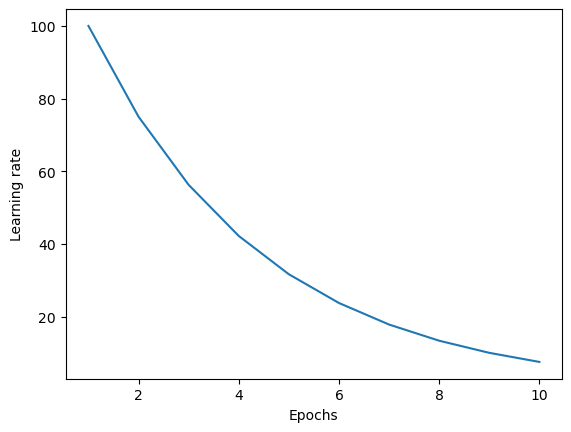

In [50]:
model = torch.nn.Linear(2, 1)
optimizer = optim.SGD(model.parameters(), lr=100)
scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
lrs = []

for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.plot(range(1, 11), lrs);

# [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau)

Уменьшает learning rate, если обучение вышло на "плато"

In [51]:
scheduler = ReduceLROnPlateau(optimizer,         # оптимизатор
                              mode='min',        # В режиме min LR будет уменьшен, когда контролируемое количество перестанет 
                                                 # уменьшаться; в режиме max он будет уменьшен, когда контролируемое количество 
                                                 # перестанет увеличиваться. 
                              factor=0.1,        # Коэффициент, на который умножается скорость обучения при уменьшении
                              patience=10,       # Количество эпох без улучшений, после которых происходит уменьшение LR
                              threshold=0.0001)  # Порог, определяющий, что считать улучшением

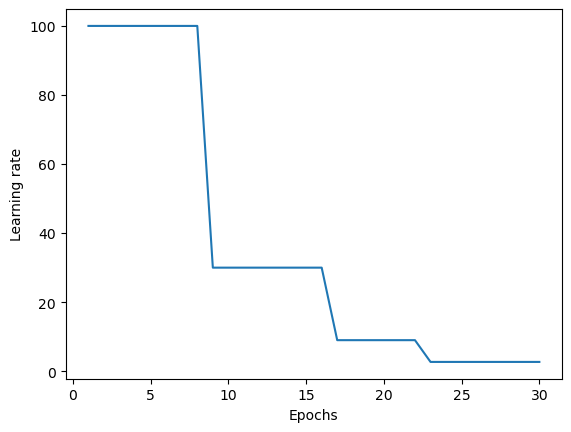

In [96]:
model = torch.nn.Linear(2, 1)
optimizer = optim.SGD(model.parameters(), lr=100)
scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.3)
lrs = []

for i in range(30):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    validation_loss = np.random.normal(1, 0.01) # имитация некой метрики
    scheduler.step(validation_loss)             # передаем метрику или loss на валидации

plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.plot(range(1, 31), lrs);

# [CosineAnnealingWarmRestarts](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html#torch.optim.lr_scheduler.CosineAnnealingWarmRestarts)

Меняет learning rate используя косинусный отжиг по формуле 

$η_t$ = $η_{min}$ + $0.5\cdot (η\_max - η\_min)\cdot (1 + cos(π \cdot \frac{T_{cur}}{T_{i}}))$

$η_t$ $-$ learning rate на шаге $t$

После завершения одного косинусного цикла (когда learning rate достигает $η_{min}$), learning rate резко сбрасывается до $η_{max}$. Это позволяет модели выходить из локального минимума, где она могла застрять, и исследовать пространство параметров более широко.

Длительность цикла / количество итерации $-$ количество вызовов scheduler.step()

Определяются параметры T_0 (длительность первого цикла) и T_mult (множитель длительности циклов). В течение первого цикла T_0 шагов learning rate уменьшается от $η_{max}$ до $η_{min}$ по косинусной кривой. Когда первый цикл завершен, learning rate резко сбрасывается до η_max. Длительность следующего цикла увеличивается в T_mult раз (т.е. T_1 = T_0 * T_mult). 

Процесс повторяется каждый раз с увеличенной продолжительностью (либо нет, если T_mult = 1) цикла и уменьшением learning rate по косинусной кривой в рамках каждого цикла.

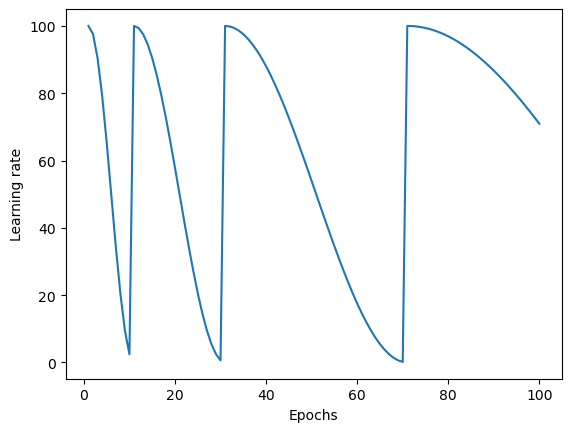

In [104]:
model = torch.nn.Linear(2, 1)
optimizer = optim.SGD(model.parameters(), lr=100)
scheduler = CosineAnnealingWarmRestarts(optimizer,  # оптимизатор
                                        T_0=10,     # определяет длительность первого косинусного цикла
                                        T_mult=2)   # определяет, во сколько раз будет увеличена длина каждого 
                                                    # последующего косинусного цикла относительно предыдущего
lrs = []

for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.plot(range(1, 101), lrs);

# Регуляризация и полезные фишечки

### L2 регуляризация 

Параметр weight_decay $-$ $Loss$ + $λ\cdot||w||_2^2$

In [107]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)  # weight_decay - коэффициент перед L2 регуляризацией

### [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

[Хорошая статья](https://proproprogs.ru/neural_network/dropout-metod-borby-s-pereobucheniem-neyronnoy-seti)

[Хорошая статья 2](https://education.yandex.ru/handbook/ml/article/tonkosti-obucheniya#:~:text=Регуляризация%20через%20ограничение%20структуры%20модели)

Основная идея Dropout заключается в случайном «выключении» (то есть временном исключении из обучения) определенного процента нейронов в сети на каждом шаге обучения. Это означает, что во время каждого прохода обучения (или каждой эпохи) случайно выбранный набор нейронов игнорируется. Это помогает предотвратить чрезмерную зависимость модели от конкретных путей и узлов в сети, что может привести к переобучению.

Сначала выбирается вероятность p, с которой каждый нейрон будет исключаться. Для каждого слоя, где применяется Dropout, генерируется случайная маска. Эта маска имеет ту же размерность, что и слой, и каждый её элемент является бинарным (0 или 1), где 1 соответствует активации нейрона, а 0 — его отключению. Эта маска генерируется заново для каждого прохода обучения и для каждого обучающего примера. Активации нейронов умножаются на эту маску, эффективно «выключая» некоторые нейроны.

В процессе обратного распространения ошибки, градиенты рассчитываются только для активных нейронов. Нейроны, которые были временно «выключены», не получают обновлений весов.

На этапе предсказания dropout ничего не меняет, то есть она «выключается».

Полезно провести аналогию с другим алгоритмом, использующим техники ансамблирования и метод случайных подпространств: речь о случайном лесе (Random Forest). При обучении сети на каждом шаге обучается лишь некоторая подсеть (некоторый подграф вычислений из исходного графа). При переходе в режим inference (то есть применения к реальным данным с целью получения результата, а не обучения) активируются сразу все подсети, и их результаты усредняются. Таким образом, сеть с dropout можно рассматривать как ансамбль из экспоненциально большого числа сетей меньшего размера. Это приводит к получению более устойчивой оценки значений целевой переменной.

Интуитивно этот метод пытается сделать так, чтобы нейронная сеть ни на один нейрон больше не могла сильно рассчитывать, так как в процессе обучения каждый нейрон может случайно занулиться, а сети все равно нужно показывать хорошую точность.

Важный момент в Dropout — значения на выходе из Dropout нужно домножать на множитель $\frac{1}{1-p}$, где $p$ — вероятность исключения нейрона, так как иначе распределение входных значений на следующем слое после Dropout будет различаться во время обучения и во время инференса модели. 

**Объяснение:**

Из объяснения из пункта про инициализацию He в случае отсутсвия Dropout следует:

$Var$ $(y_i)$ = $E$ $(x_i)^2$ $\cdot$ $Var$ $(w_i)$ + $E$ $(w_i)^2$ $\cdot$ $Var$ $(x_i)$ + $Var$ $(w_i)$ $\cdot$ $Var$ $(x_i)$ 

$(E$ $(w_i)$ = $0,$ $E$ $(x_i)$ ≠ $0)$ $=>$ $Var$ $(y_i)$ = $E$ $(x_i)^2$ $\cdot$ $Var$ $(w_i)$ + $Var$ $(w_i)$ $\cdot$ $Var$ $(x_i)$ = $Var$ $(w_i)$ $\cdot$ $(E$ $(x_i)^2$ + $Var$ $(x_i))$ = $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)$

$Var$ $(y)_1$ = $Var$ $(\sum_{i=1}^{n_{in}}y_i)$ = $\sum_{i=1}^{n_{in}}Var(y_i)$ = $n_{in}$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)_{1}$

В случае Dropout следует:

Пусть после обнуления некоторых нейронов осталось $n$ нейронов, где $n$ = $n_{in}\cdot (1-p)$, то есть исходное количество нейронов, умноженное на вероятность того, что нейрон не будет исключен.

$Var$ $(y)_{2}$ = $Var$ $(\sum_{i=1}^{n}w_i\cdot x_i)$ = $\sum_{i=1}^{n}Var(w_i\cdot x_i)$ = $n$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)_{2}$ = $n_{in}\cdot (1-p)$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)_{2}$

Так как из распределения Бернулли $1$ будет с вероятностью $(1-p)$ и $0$ с вероятностью $p$

$E$ $(x_i^2)_{2}$ = $\sum(x_i^{2}\cdot \frac{1}{n} \cdot [(1-p) + 0\cdot p]\,)$ = $\sum(x_i^{2}\cdot \frac{1}{n} \cdot (1-p))$ = $(1-p)\cdot \sum(x_i^{2}\cdot \frac{1}{n})$ = $(1-p)\, \cdot$ $E$ $(x_i^2)_{1}$

$Var$ $(y)_{2}$ = $n_{in}\cdot (1-p)$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $(1-p)\, \cdot$ $E$ $(x_i^2)_{1}$ = $n_{in}\cdot (1-p)^2$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)_{1}$

Дисперсии различаются лишь множителем $(1-p)^2$, поэтому, чтобы стабилизировать дисперсию, нужно умножать $x_i$ на $\frac{1}{1-p}$.

$Var$ $(\sum_{i=1}^{n}w_i\cdot x_i\cdot \frac{1}{1-p})$ = $\frac{1}{(1-p)^2}\cdot Var$ $(\sum_{i=1}^{n}w_i\cdot x_i)$ = $\frac{1}{(1-p)^2}\cdot$ $n_{in}\cdot (1-p)^2$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)_{1}$ = $n_{in}$ $\cdot$ $Var$ $(w_i)$ $\cdot$ $E$ $(x_i^2)_{1}$ = $Var$ $(y)_1$

**Объяснение на пальцах:**

Пусть входные значения $x_i$ принадлежат отрезку $[-a, a]$, весовые коэффициенты $w_i$ принадлежат отрезку $[-b, b]$ и всего $n$ нейронов в левом слое. Получаем $y_1$ = $\sum_{i=1}^n w_i\cdot x_i$. Тогда $y_1$ принадлежит отрезку $[-nba, nba]$

В случае Dropout имеем $y_2$ = $\sum_{i=1}^{n\cdot(1-p)} w_i\cdot x_i$. Тогда $y_2$ принадлежит отрезку $[-(1-p)nba, (1-p)nba]$. Чтобы отрезки в первом и втором случаях совпадали, нужно брать входные значения $x_i$ с множителем $\frac{1}{1-p}$
 
На практике Dropout — специальный слой, который в процессе обучения умножает на множитель $\frac{1}{1-p}$ и часть нейронов слоя зануляет. 

In [230]:
dropout = nn.Dropout(p=0.6)  # 1 / (1 - 0.6) = 2.5
inp = torch.randn(2, 5)
inp

tensor([[-0.2594,  1.3940, -0.1239, -0.4558, -0.3184],
        [-0.6501, -0.7475, -0.3159,  0.2069, -1.2937]])

In [231]:
dropout(inp)

tensor([[-0.6485,  0.0000, -0.0000, -1.1396, -0.7959],
        [-0.0000, -0.0000, -0.7898,  0.5173, -0.0000]])

# Batch normalization 

[Статья](https://proproprogs.ru/neural_network/batch-normalization-batch-normalizaciya-chto-eto-takoe)

[Видео](https://www.youtube.com/watch?v=Y9a5EfqM7RM&ab_channel=DeepLearningSchool)

У нейронных сетей есть проблема, которая называется внутренним ковариационным сдвигом. Этот термин описывает явление, при котором распределение входных данных каждого слоя нейронной сети меняется в процессе обучения, из-за чего сети становится сложнее обучать. Например, мы подаем данные из нормального распределения, но после скалярного произведения входных значений на веса и применений ReLU распределение значений становится иным. Можно понимать еще так, что если на очередном шаге градиентного спуска меняются веса одного из первых слоев, то это неминуемо приводит к изменению распределения активаций выходов этого слоя. А значит, всем последующим слоям надо адаптироваться к по-новому распределенным данным. То есть параметры предыдущих слоев изменяются во время обучения, влияя на данные текущего слоя. Для решения этой проблемы придумали Batch normalization.

Так думали создатели данной техники, но вышла [статья](https://arxiv.org/pdf/1805.11604), где авторы опровергли причины эффективности Batch normalization. Традиционно считалось, что этот подход помогает бороться с "внутренним ковариационным сдвигом", но авторы привели другое объяснение: BatchNorm делает ландшафт оптимизации (поверхность функции потерь) значительно более гладким. 

Это приводит к следующим эффектам:

- Градиенты становятся более предсказуемыми и стабильными.

- Это позволяет использовать более высокие learning rate (скорость обучения).

- Обучение становится быстрее и устойчивее.

Для опровержения авторы сравнили 3 модели: без Batch normalization, с Batch normalization и с Batch normalization + некий шум с ненулевым средним значением и неединичной дисперсией, который призван создать сильный ковариационный сдвиг. Оказалось, что обе эти сети (с BatchNorm и "зашумлённым" BatchNorm) работают значительно лучше, чем стандартная сеть без BatchNorm. Результаты показывают, что даже при сильном нарушении стабильности распределений входных данных (из-за добавления шума) BatchNorm всё равно демонстрирует высокую производительность. Это ставит под сомнение утверждение о том, что успех BatchNorm связан именно со стабилизацией распределений.

Использование batch normalization гарантирует, что каждая компонента представления на выходе будет иметь контролируемое среднее и дисперсию. Достигается это следующим образом:

**Во время обучения** Пусть батч состоит из $\mathbf{x_i}$ (каждый $\mathbf{x_i}$ - вектор, подающийся на вход). Здесь все операции надо воспринимать как векторные поэлементные операции.

$$\begin{aligned}
\mu_{\mathcal{B}} & \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i} \\
\sigma_{\mathcal{B}}^{2} & \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2} \\
\widehat{x}_{i} & \leftarrow \frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}} \\
y_{i} & \leftarrow \gamma \widehat{x}_{i}+\beta
\end{aligned}$$

$\gamma, \beta$ $-$ обучаемые параметры (тоже векторы), позволяющие настраивать в ходе обучения оптимальные значения матожидания и дисперсии выходного слоя. $m$ $-$ размер батча. 

**Во время предсказания**

Мы делаем то же самое, но у нас нет батча. Поэтому в качестве $\mu_{\mathcal{B}}$ и $\sigma_{\mathcal{B}}$ мы используем среднее и стандартное отклонение признака во всем датасете. Обычно нам не хочется после обучения еще раз применять сеть ко всем примерам из обучающего датасета, чтобы вычислить эти статистики, поэтому вместо них мы используем $\overline{\mu_{\mathcal{B}}}$ и $\overline{\sigma_{\mathcal{B}}}$ которые были получены в ходе обучения как скользящее среднее всех $\mu_{\mathcal{B}}$ и $\sigma_{\mathcal{B}}$.

$\overline{\mu_{\mathcal{B}}}$ = $\overline{\mu_{\mathcal{B}}}\cdot (1-\lambda)$ + $\mu_{\mathcal{B}}\cdot \lambda$

$\overline{\sigma_{\mathcal{B}}^2}$ = $\overline{\sigma_{\mathcal{B}}^2}\cdot (1-\lambda)$ + $\sigma_{\mathcal{B}}^2\cdot \lambda$

**В итоге** Batch normalization имеет следующие плюсы:

* Более быстрое обучение. Можно брать learning rate побольше.
* Обучение более глубоких сетей.
* Регуляризация.
* Повышение точности моделей.
* Не так важна инициализация весов

**Важный момент**

[Stackoverflow](https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network)

В обычном случае, мы работаем с каждым признаком, считаем среднее и стандартное отклонение для признака в пределах одного батча. Все меняется в случае сверточных слоев. В сверточных сетях мы хотим сохранить свойство "если в разных частях картинки находятся одинаковые наборы пикселей, то соответствующие выходы сверточного слоя будут одинаковыми". Если бы мы применяли алгоритм, который описан выше, то получилось бы так, что для 2 одинаковых наборов пикселей внутри одного канала (карты признаков), которые находятся в разных частях картинки, мы получили бы разные значения на выходе Batch normalization. (Мы получили бы $mean$ и $std$ для каждого пикселя каждого канала, поэтому для каждого пикселя из каждого канала происходила бы нормализация). Чтобы решить эту проблему, можно усреднять не только по batch_size, но и по height и weight координатам.

Пример: На вход подается многомерный тензор размера **[B, C, H, W]**. Где B - количество батчей, H - высота картинок, W - ширина картинок, а C - количество каналов. Тогда обычный батчнорм выполнял бы нормирование так:

```python
# t - это входящий тензор формы [B, C, H, W]
# среднее значение и стандартное отклонение вычисляются по оси 0 и имеют форму [C, H, W] 
mean = mean(t, axis=0)
std = std(t, axis=0)
for i in 0..B-1:
    out[i,:,:,:] = norm(t[i,:,:,:], mean, std)
```

В то время как батчнорм для сверточных сетей:

```python
# t - это входящий тензор формы [B, C, H, W]
# но среднее значение и стандартное отклонение вычисляются по осям (0, 2, 3) и имеют форму [C]
mean = mean(t, axis=(0, 2, 3))
std = std(t, axis=(0, 2, 3))
for i in 0..B-1, x in 0..H-1, y in 0..W-1:
    out[i,:,x,y] = norm(t[i,:,x,y], mean, std)
```

То есть среднее и стандартное отклонение вычисляются для каждого канала, где каждый канал представляет собой матрицу. Для каждого элемента матрицы будет одно и то же среднее и стандартное отклонение, а по предложенному алгоритму было бы так, что для каждого элемента матрицы было бы свое среднее и свое стандартное отклонение. 

# [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

**torch.nn.BatchNorm1d ( num_features, eps = 1e- 05, momentum = 0.1, affine = True ... )**

num_features = числу **C** из формы **(N, C, L)** или **(N, C)** входного тензора.

На вход принимает тензор формы **(N, C, L)** или **(N, C)**, где **N** - размер батча, **С** - количество признаков или каналов, **L** - длина последовательности.

На выходе тензор той же формы, что и на входе.

In [691]:
bn = nn.BatchNorm1d(5,                # размерность вектора параметров масштабирования std и вектора сдвига mean.
                    momentum=0.1,     # используется для вычисления скользящего среднего running_mean и дисперсии running_var.
                    affine = False)   # Определяет, будет ли BatchNorm использовать обучаемые параметры γ,ꞵ   

In [692]:
bn.running_mean, bn.running_var

(tensor([0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1.]))

In [693]:
x = torch.randn(3, 5)

In [694]:
x

tensor([[ 0.6075, -0.8080,  0.1757,  0.8721, -0.4504],
        [ 0.2453,  0.8983, -1.0317,  1.7532,  0.6079],
        [ 2.1194, -1.8973, -0.4699,  0.2765, -1.1416]])

In [695]:
bn(x)

tensor([[-0.4722, -0.1788,  1.2520, -0.1568, -0.1701],
        [-0.9184,  1.3043, -1.1954,  1.2956,  1.3009],
        [ 1.3905, -1.1255, -0.0566, -1.1388, -1.1308]])

In [696]:
(x - x.mean(axis=0)) / x.std(axis=0, correction=0)  # что происходит под капотом

tensor([[-0.4722, -0.1788,  1.2521, -0.1568, -0.1701],
        [-0.9184,  1.3043, -1.1955,  1.2956,  1.3009],
        [ 1.3906, -1.1255, -0.0566, -1.1388, -1.1308]])

In [697]:
bn.running_mean, bn.running_var

(tensor([ 0.0991, -0.0602, -0.0442,  0.0967, -0.0328]),
 tensor([0.9988, 1.0986, 0.9365, 0.9552, 0.9776]))

# [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)

**torch.nn.BatchNorm2d ( num_features, eps = 1e- 05, momentum = 0.1, affine = True ... )**

num_features = числу **C** из формы **(N, C, H, W)** входного тензора.

То же самое, что и BatchNorm1d, только применяется для тензоров формы **(N, C, H, W)**, где **N** - размер батча, **С** - количество каналов, **H** - высота, **W** - ширина. То есть применяется для сверточных нейросетей.

In [687]:
bn = nn.BatchNorm2d(2,              # размерность вектора параметров масштабирования std и вектора сдвига mean.
                    momentum=0.2,   # используется для вычисления скользящего среднего running_mean и дисперсии running_var.
                    affine=True)    # Определяет, будет ли BatchNorm использовать обучаемые параметры γ,ꞵ   

In [688]:
bn.running_mean, bn.running_var

(tensor([0., 0.]), tensor([1., 1.]))

In [689]:
bn( torch.randn(1, 2, 3, 3) )

tensor([[[[-1.0718,  2.0470, -0.0351],
          [-0.0190, -1.3330,  0.9814],
          [ 0.5379, -0.6453, -0.4621]],

         [[-1.0833,  0.0032,  0.8953],
          [-1.3866, -1.3942,  0.2440],
          [ 0.7903,  0.4137,  1.5176]]]], grad_fn=<NativeBatchNormBackward0>)

In [707]:
bn.running_mean, bn.running_var

(tensor([ 0.0991, -0.0602, -0.0442,  0.0967, -0.0328]),
 tensor([0.9988, 1.0986, 0.9365, 0.9552, 0.9776]))